In [26]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sn
import gensim

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report

from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score  # Add this import for accuracy_score
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel


# Load and preprocess the dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', encoding='utf-8')
df.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# 1. Exploratory Data Analysis

# 1.1 Handling Null Values

In [27]:
df.isna().any()
df.isna().sum()

review       0
sentiment    0
dtype: int64

# 1.2 Handling Duplicate Values

In [28]:
df['review'].nunique()


49582

In [29]:
df['review'].drop_duplicates(inplace = True)


In [30]:
df['review'].nunique()


49582

In [31]:
df.shape


(50000, 2)

In [32]:
#Summary of the dataset
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [33]:
original_rows = df.shape[0]
df.drop_duplicates(subset='review', inplace=True)
remaining_rows = df.shape[0]

if remaining_rows < original_rows:
    print("Duplicates have been dropped.")
else:
    print("No duplicates found.")

Duplicates have been dropped.


In [34]:
df.drop_duplicates(subset='review', inplace=True)
total_rows = len(df)
print("Total rows after dropping duplicates:", total_rows)

Total rows after dropping duplicates: 49582


# 1.3 Class Distributions

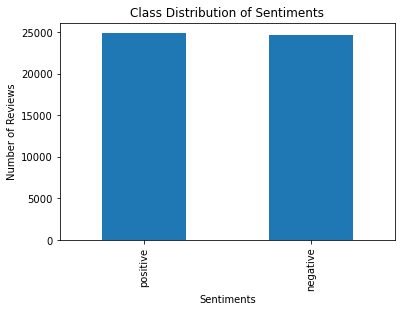

In [35]:
# Create a bar plot of the class distribution
class_counts = df['sentiment'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Number of Reviews')
plt.show()

In [36]:
#sentiment count
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

# 1.4 Word Counts

In [37]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(df['review'].values)
# Remove URLs, mentions, and hashtags from the text
all_text = re.sub(r'http\S+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)

In [38]:
# Split the text into individual words
words = all_text.split()

In [39]:
# Remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

In [40]:
# Count the frequency of each word
word_counts = Counter(words)
top_words = word_counts.most_common(100)
top_words

[('I', 131363),
 ('/><br', 100211),
 ('The', 66714),
 ('movie', 60288),
 ('film', 53897),
 ('one', 41026),
 ('like', 35729),
 ('This', 24157),
 ('would', 23381),
 ('good', 22419),
 ('It', 21314),
 ('really', 21169),
 ('even', 20809),
 ('see', 20176),
 ('-', 18065),
 ('get', 17197),
 ('much', 16681),
 ('story', 16337),
 ('time', 15192),
 ('make', 14750),
 ('could', 14551),
 ('also', 14504),
 ('people', 14284),
 ('great', 14283),
 ('/>The', 14230),
 ('first', 14160),
 ('made', 13289),
 ('think', 12979),
 ('bad', 12726),
 ('many', 12096),
 ('<br', 11964),
 ('never', 11895),
 ('two', 11387),
 ('But', 11328),
 ('little', 11107),
 ('it.', 11026),
 ('way', 10989),
 ('And', 10967),
 ('well', 10716),
 ('watch', 10587),
 ('know', 10571),
 ('movie.', 10561),
 ('seen', 10466),
 ('characters', 10348),
 ('character', 10229),
 ("It's", 10149),
 ('movies', 10064),
 ('love', 9972),
 ('best', 9846),
 ('ever', 9833),
 ('A', 9590),
 ('In', 9408),
 ('films', 9346),
 ('still', 9333),
 ('plot', 9227),
 ('act

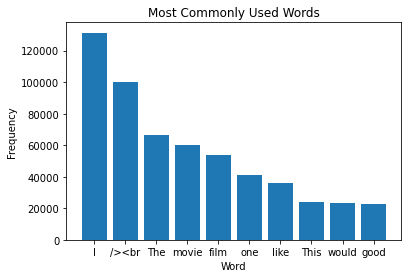

In [41]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

# 2. NLP

# 2.1. Data Cleaning

In [42]:
#Removing HTML Tags
def remove_html_tags(text):
    re_html = re.compile('<.*?>')
    return re_html.sub(r'', text)

print(f"Before removing HTML tags: {df['review'][1][:70]}")

df['review'] = df['review'].apply(remove_html_tags)

print(f"After removing HTML tags : {df['review'][1][:70]}")

Before removing HTML tags: A wonderful little production. <br /><br />The filming technique is ve
After removing HTML tags : A wonderful little production. The filming technique is very unassumin


In [43]:
#Lowercasting 
def convert_lowercase(column):
    column = column.str.lower()
    return column

print(f"Before applying lower casting: {df['review'][0][:10]}")

df['review'] = convert_lowercase(df['review'])

print(f"After applying lower casting : {df['review'][0][:10]}")

Before applying lower casting: One of the
After applying lower casting : one of the


In [44]:
#Removing special characters

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column

print(f"After removing special characters : {df['review'][0][:100]}")

df['review']=df['review'].apply(remove_special_characters)

print(f"After removing special characters : {df['review'][0][:100]}")

After removing special characters : one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. the
After removing special characters : one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they 


In [45]:
#Removing Punctuations
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

print(f"Tweet before removing punctuation: {df['review'][0]}")

df['review'] = df['review'].apply(remove_punc)

print(f"Tweet after removing punctuation : {df['review'][0]}")

Tweet before removing punctuation: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows

In [46]:
#Removing stop words
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

def remove_stopwords(text):
    stop_words = nltk.corpus.stopwords.words("english")
    text = " ".join([word for word in text.split() if word not in stop_words])
    
    return text

print(f"Tweet before removing stop words : {df['review'][0]}")

df['review'] = df['review'].apply(remove_stopwords)

print(f"Tweet after removing stop words : {df['review'][0]}")

Tweet before removing stop words : one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows

In [47]:
#Stemming
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_stemming(text):
    new_text = [ps.stem(word) for word in text.split()]
    return ' '.join(new_text)

print(f"Tweet before removing stemming : {df['review'][0]}")

df['review'] = df['review'].apply(perform_stemming)

print(f"Tweet after removing stemming : {df['review'][0]}")


Tweet before removing stemming : one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill orde

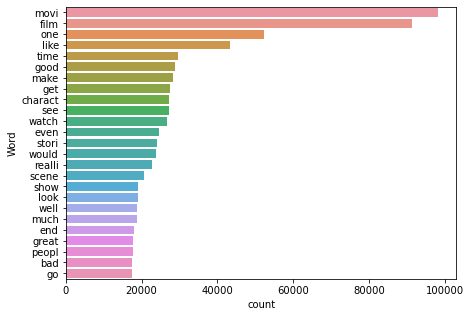

In [48]:
# visualising frequentwords

def showmostfrequentwords(text,no_of_words):
    
    allwords = ' '.join([char for char in text])
    allwords = allwords.split()
    fdist = nltk.FreqDist(allwords)
    
    wordsdf = pd.DataFrame({'word':list(fdist.keys()),'count':list(fdist.values())})
    
    df = wordsdf.nlargest(columns="count",n = no_of_words)
    
    plt.figure(figsize=(7,5))
    ax = sn.barplot(data=df,x = 'count',y = 'word')
    ax.set(ylabel = 'Word')
    plt.show()
    
    return wordsdf
    
    
# 25 most frequent words
freq_df = showmostfrequentwords(df['review'],25)

# 3. ML Modelling

In [52]:
log_reg = LogisticRegression(max_iter=1000)
log_reg = LogisticRegression(solver='liblinear')

# Map 'positive' to 1 and 'negative' to 0
y = np.array(df['sentiment'].map({'positive': 1, 'negative': 0}))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], y, test_size=0.2, random_state=42)

# Word2Vec Model
sentences = [review.split() for review in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=8, sg=0)

# Custom Transformer for Word2Vec Word Embeddings
class Word2VecEmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.get_word_embeddings(review) for review in X])

    def get_word_embeddings(self, text):
        words = text.split()
        embeddings = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(100)


class LDATopicModelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_topics=5, passes=10):
        self.num_topics = num_topics
        self.passes = passes

    def fit(self, X, y=None):
        # Tokenize the text data and create a Gensim Dictionary and Corpus
        tweet_tokens = [review.split() for review in X]
        dictionary = Dictionary(tweet_tokens)
        corpus = [dictionary.doc2bow(tokens) for tokens in tweet_tokens]

        # Train the LDA model
        self.lda_model = LdaModel(corpus, num_topics=self.num_topics, id2word=dictionary, passes=self.passes)
        return self

    def transform(self, X):
        # Tokenize the text data and create a Gensim Dictionary and Corpus
        tweet_tokens = [review.split() for review in X]
        dictionary = Dictionary(tweet_tokens)
        corpus = [dictionary.doc2bow(tokens) for tokens in tweet_tokens]

        # Get topic distribution for each document
        topic_distributions = [self.lda_model.get_document_topics(doc) for doc in corpus]
        topic_matrix = np.zeros((len(X), self.num_topics))
        for i, doc_topics in enumerate(topic_distributions):
            for topic, prob in doc_topics:
                topic_matrix[i, topic] = prob
                
        # Print the topics
        self.print_topics()
        
        return topic_matrix

    def print_topics(self):
        # Print the topics with their corresponding word distributions
        topics = self.lda_model.show_topics(num_topics=self.num_topics, num_words=10, formatted=False)
        for i, topic in topics:
            print(f"Topic {i + 1}: {' '.join([word for word, _ in topic])}")


    
# Create pipelines for BOW, Word2Vec, and TF-IDF
bow_pipeline = Pipeline([
    ('count_vec', CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')),
    ('log_reg', LogisticRegression())
])

word2vec_pipeline = Pipeline([
    ('word2vec_emb', Word2VecEmbeddingTransformer(word2vec_model)),
    ('log_reg', LogisticRegression())
])

tfidf_pipeline = Pipeline([
    ('tfidf_vec', TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')),
    ('log_reg', LogisticRegression())
])

lda_pipeline = Pipeline([
    ('lda_topics', LDATopicModelTransformer(num_topics=5, passes=10)),  
    ('log_reg', LogisticRegression())
])
# Fit and transform the data using the pipelines

# BOW
bow_pipeline.fit(X_train, y_train)
y_pred_bow = bow_pipeline.predict(X_test)

# Word2Vec
word2vec_pipeline.fit(X_train, y_train)
y_pred_word2vec = word2vec_pipeline.predict(X_test)

# TF-IDF
tfidf_pipeline.fit(X_train, y_train)
y_pred_tfidf = tfidf_pipeline.predict(X_test)


# LDA
lda_pipeline.fit(X_train, y_train)
y_pred_lda = lda_pipeline.predict(X_test)

# Evaluate Model
accuracy_bow = accuracy_score(y_test, y_pred_bow)
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

print("Accuracy (BOW):", accuracy_bow)
print("Accuracy (Word2Vec):", accuracy_word2vec)
print("Accuracy (TF-IDF):", accuracy_tfidf)
print("Accuracy (LDA):", accuracy_lda)

# Evaluate Model and Print Classification Report
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['negative', 'positive'])
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)
    print("=" * 40)
    
# BOW
evaluate_model(y_test, y_pred_bow, "BOW")

# Word2Vec
evaluate_model(y_test, y_pred_word2vec, "Word2Vec")

# TF-IDF
evaluate_model(y_test, y_pred_tfidf, "TF-IDF")

# LDA
evaluate_model(y_test, y_pred_lda, "LDA")


/Users/maymekms/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maymekms/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Topic 1: film stori one charact movi time life make see love
Topic 2: film play great one perform role best good cast music
Topic 3: movi film like one watch good realli see get even
Topic 4: get man one take kill woman two play go murder
Topic 5: vampir batman jacki chan match kong santa muppet christma holm
Topic 1: film stori one charact movi time life make see love
Topic 2: film play great one perform role best good cast music
Topic 3: movi film like one watch good realli see get even
Topic 4: get man one take kill woman two play go murder
Topic 5: vampir batman jacki chan match kong santa muppet christma holm
Accuracy (BOW): 0.8531814056670364
Accuracy (Word2Vec): 0.8539881012402945
Accuracy (TF-IDF): 0.8559040032267823
Accuracy (LDA): 0.5007562770999294
Model: BOW
Accuracy: 0.8531814056670364
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.85      4939
    positive       0.84      0.87      0.86      4978

   

In [51]:
# Get the feature names from the CountVectorizer
feature_names = bow_pipeline.named_steps['count_vec'].get_feature_names()

# Get the coefficients of the trained logistic regression model
coefficients = bow_pipeline.named_steps['log_reg'].coef_[0]

# Create a dictionary of word-coefficient pairs
word_coeff_dict = dict(zip(feature_names, coefficients))

# Sort the dictionary based on coefficients to get most important words
sorted_words = sorted(word_coeff_dict.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 positive words
top_positive_words = [word for word, coeff in sorted_words[:10]]
print("Top Positive Words:", top_positive_words)

# Display the top 10 negative words
top_negative_words = [word for word, coeff in sorted_words[-10:]]
print("Top Negative Words:", top_negative_words)

Top Positive Words: ['superb', 'excel', 'solid', 'delight', 'fantast', 'perfectli', 'brilliant', 'amaz', 'awesom', 'hilari']
Top Negative Words: ['pointless', 'pathet', 'lame', 'embarrass', 'dull', 'laughabl', 'aw', 'poorli', 'worst', 'wast']


In [54]:
# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf_pipeline.named_steps['tfidf_vec'].get_feature_names()

# Get the coefficients of the trained logistic regression model
coefficients = tfidf_pipeline.named_steps['log_reg'].coef_[0]

# Create a dictionary of word-coefficient pairs
word_coeff_dict = dict(zip(feature_names, coefficients))

# Sort the dictionary based on coefficients to get most important words
sorted_words = sorted(word_coeff_dict.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 positive words
top_positive_words = [word for word, coeff in sorted_words[:10]]
print("Top Positive Words:", top_positive_words)

# Display the top 10 negative words
top_negative_words = [word for word, coeff in sorted_words[-10:]]
print("Top Negative Words:", top_negative_words)



Top Positive Words: ['excel', 'great', 'perfect', 'amaz', 'favorit', 'best', 'superb', 'brilliant', 'fantast', 'enjoy']
Top Negative Words: ['dull', 'poorli', 'wors', 'poor', 'terribl', 'bore', 'bad', 'aw', 'wast', 'worst']
